In [70]:
# Dependencies
import requests
import logging
import pandas as pd

In [71]:
# Define URL parameters
league_id = "564698"
year = ['2023','2022','2021','2020','2019','2018']

In [72]:
swid = "{823B7B7A-5AFC-4B2E-A22A-B2D690D236A8}"
espn_s2 = "AEBMf%2FfmL20PESZFBMdSRkR9HHsxOE%2FvAirc8HkQxtgX9tbG8vsxqa8Qm83LNJam6rJeMAWfmMVt3b2EuNYu7%2FATa0vER%2FTQIfoZRRg4ItNjN8MkU%2FBdNeTsOGei2ZJDgGX3zWxfxkysoQgRaVkikEHDHZtxlY9ZBtk3NrSUE%2BlaTWzbsfsEGlIgNzN4YG4QuUV7GxteDw1hUd%2Fb2sfdvew0ypoKcXrE51OQL5AgdfnH144uN1YmgFd3nNdBe%2FBIadjuJ2TZ7LAzAI7z1P6x7QhiG1Ah7RMTEzO7MDzoLdMODQ%3D%3D"

In [73]:
seasons = []
for yr in year:
    url = "https://lm-api-communication.fantasy.espn.com/apis/v3/games/ffl/seasons/"+yr+"/segments/0/leagues/564698"
    matchup_response = requests.get(url, cookies={"swid": swid,
                          "espn_s2": espn_s2},params={"view": "mMatchup"})
    matchup_json = matchup_response.json()
    df = [
    [
        game['matchupPeriodId'],
        game['home']['teamId'], 
        game['home'].get('totalPoints', 0),  # Using .get() to handle missing points
        game.get('away', {}).get('teamId', 'N/A'),  # Defaulting to 'N/A' if 'away' key is missing
        game.get('away', {}).get('totalPoints', 0)  # Defaulting to 0 if 'away' key or totalPoints is missing
    ]
    for game in matchup_json['schedule']
    ]
    df = pd.DataFrame(df, columns=['Week', 'HomeTeamId', 'HomeTotalPoints', 'AwayTeamId', 'AwayTotalPoints'])
    df['Type'] = ['Regular' if w<=14 else 'Playoff' for w in df['Week']]
    df['Year'] = yr
    seasons.append(df)

In [74]:
df_sch = pd.concat(seasons)

In [75]:
df_sch.to_csv('df_sch.csv')

In [76]:
seasons_tm = []
for yr in year:
    url = "https://lm-api-communication.fantasy.espn.com/apis/v3/games/ffl/seasons/"+yr+"/segments/0/leagues/564698"
    team_response = requests.get(url, cookies={"swid": swid,
                          "espn_s2": espn_s2},params={"view": "forTeamId"})
    team_json = team_response.json()
    tm = [
    [
        team['abbrev'],
        team['id'],
        team['owners']
    ]
    for team in team_json['teams']
    ]
    
    tm1 = pd.DataFrame(tm, columns=['Abbr', 'TeamID','OwnerID_2'])

    tm = [
    [
        team['displayName'],
        team['id'],
    ]
    for team in team_json['members']
    ]
    
    tm2 = pd.DataFrame(tm, columns=['displayName','OwnerID'])

    # Creating the Cartesian product directly
    dataFrameFull = pd.merge(tm1, tm2, how='cross')

    # Checking if OwnerID_2 is a substring of OwnerID
    dataFrameFull['match'] = dataFrameFull.apply(lambda x: x.OwnerID in x.OwnerID_2, axis=1)
    
    dataFrameFull['Year'] = yr
    seasons_tm.append(dataFrameFull[dataFrameFull['match']])

In [77]:
df_tm = pd.concat(seasons_tm)

In [78]:
df_tm.to_csv('df_tm.csv')

In [79]:
seasons_tm_1 = []
for yr in year:
    url = "https://lm-api-communication.fantasy.espn.com/apis/v3/games/ffl/seasons/"+yr+"/segments/0/leagues/564698"
    team_response = requests.get(url, cookies={"swid": swid,
                          "espn_s2": espn_s2},params={"view": "mTeam"})
    team_json = team_response.json()
    tm = [
    [
        team['displayName'],
        team['firstName'],
        team['lastName'],
        team['id']
    ]
    for team in team_json['members']
    ]
    
    tm1 = pd.DataFrame(tm, columns=['DisplayName', 'First','Last','OwnerID'])
    tm1['Year'] = yr
    seasons_tm_1.append(tm1)

In [80]:
df_tm1 = pd.concat(seasons_tm_1)

In [81]:
df_tm1.to_csv('df_tm1.csv')

In [82]:
#df_tm.merge(df_tm1).groupby(['TeamID'])['OwnerID'].nunique()

In [83]:
slotcodes = {
    0 : 'QB', 1 : 'QB',
    2 : 'RB', 3 : 'RB',
    4 : 'WR', 5 : 'WR',
    6 : 'TE', 7 : 'TE',
    16: 'D/ST',
    17: 'K',
    20: 'Bench',
    21: 'IR',
    23: 'Flex'
}

In [84]:
def get_matchups(league_id, season, week, swid='', espn=''):
    ''' 
    Pull full JSON of matchup data from ESPN API for a particular week.
    '''
    
    url = 'https://lm-api-reads.fantasy.espn.com/apis/v3/games/ffl/seasons/'+str(season) + '/segments/0/leagues/' + str(league_id)+'?scoringPeriodId='+str(week)+ '&view=mMatchup&view=mMatchupScore' 

    r = requests.get(url,
                     cookies={"SWID": swid, "espn_s2": espn})
    return r.json()

def get_slates(json,season, week):
    '''
    Constructs week team slates with slotted position, 
    position, and points (actual and ESPN projected),
    given full matchup info (`get_matchups`)
    '''
    
    slates = {}
    slates_ls = []

    for team in d['teams']:
        slate = []
        for p in team['roster']['entries']:
            # get name
            if p.get('playerPoolEntry') and p['playerPoolEntry'].get('player'):
                name = p['playerPoolEntry']['player']['fullName']
            else:
                name = "Unknown Player"

            # get actual lineup slot
            slotid = p['lineupSlotId']
            slot = slotcodes[slotid]

            # get projected and actual scores
            act, proj = 0, 0
            if p.get('playerPoolEntry') and p['playerPoolEntry'].get('player'):
                for stat in p['playerPoolEntry']['player']['stats']:
                    if stat['scoringPeriodId'] != week:
                        continue
                    if stat['statSourceId'] == 0:
                        act = stat['appliedTotal']
                    elif stat['statSourceId'] == 1:
                        proj = stat['appliedTotal']
                    else:
                        print('Error')
            else:
                continue

            # get type of player
            pos = 'Unk'
            if p.get('playerPoolEntry') and p['playerPoolEntry'].get('player'):
                ess = p['playerPoolEntry']['player']['eligibleSlots']
                if 0 in ess: pos = 'QB'
                elif 2 in ess: pos = 'RB'
                elif 4 in ess: pos = 'WR'
                elif 6 in ess: pos = 'TE'
                elif 16 in ess: pos = 'D/ST'
                elif 17 in ess: pos = 'K'
            else:
                continue
            #teamid = team['id']
            
            
            slate.append([name, season, week, slotid, slot, pos, act, proj])

        slate = pd.DataFrame(slate, columns=['Name','Year', 'Week', 'SlotID', 'Slot', 'Pos', 'Actual', 'Proj'])
        #slates_ls.append(slate)
        slates[team['id']] = slate

    return slates

def compute_pts(slates, posns, struc):
    '''
    Given slates (`get_slates`), compute total roster points:
    actual, optimal, and using ESPN projections.
    
    Parameters
    --------------
    slates : `dict` of `DataFrames`
        (from `get_slates`)
    posns : `list`
        roster positions, e.g. ['QB', 'RB', 'WR', 'TE']
    struc : `list`
        slots per position, e.g. [1,2,2,1]
        
    * This is not flexible enough to handle "weird" leagues
    like 6 Flex slots with constraints on # total RB/WR
    
    Returns
    --------------
    `dict` of `dict`s with actual, ESPN, and optimal points
    '''
    
    data = {}
    for tmid, slate in slates.items():
        pts = {'opts': 0, 'epts': 0, 'apts': 0}

        # ACTUAL STARTERS
        pts['apts'] = slate.query('Slot not in ["Bench", "IR"]').filter(['Actual']).sum().values[0]

        # OPTIMAL and ESPNPROJ STARTERS
        for method, cat in [('Actual', 'opts'), ('Proj', 'epts')]:
            flex_candidates_act = []
            flex_candidates_proj = []
            fcp = []
            for pos, num in zip(posns, struc):
                # actual/projection points, sorted by the respective method
                sorted_slate = slate.query('Pos == @pos').sort_values(by=method, ascending=False)
                #print(sorted_slate.info())
                #print(method, pos,sorted_slate.iloc[:num].filter(['Actual']).sum().values[0])
                # Sum up the points for the starters in this position
                
                pts[cat] += sorted_slate.iloc[:num].filter(['Actual']).sum().values[0]
                

                # Add the next best as a flex candidate
                if pos in ['RB', 'WR', 'TE'] and len(sorted_slate) > num:
                    if method=="Proj":
                        
                        flex_candidates_proj.append(sorted_slate.iloc[num:])
                    else:
                        flex_candidates_act.extend(sorted_slate.iloc[num:].filter(['Actual']).values[:, 0])
                    #print(tmid, method, pos,flex_candidates_act,fcp)
            if flex_candidates_proj:
                fcp.extend(pd.concat(flex_candidates_proj).sort_values(by="Proj").iloc[num:].filter(['Actual']).values[:, 0])
                #print(fcp)
                top_flex = fcp[-num:]
                pts[cat] += sum(top_flex)
                #print(tmid, pos,method, num , sum(top_flex))
            # Add the best flex option to the total
            if flex_candidates_act:
                top_flex = sorted(flex_candidates_act, reverse=True)[:num]
                pts[cat] += sum(top_flex)
                
                #print(tmid, pos,method, num , sum(top_flex))
        
        data[tmid] = pts
        
    return data

#def get_teamnames(league_id, season, week, swid='', espn=''):
    #url = 'https://lm-api-communication.fantasy.espn.com/apis/v3/games/ffl/seasons/' + \
      #str(season) + '/segments/0/leagues/' + str(league_id)
    
    #r = requests.get(url + '?view=mTeam',
                  #params={'scoringPeriodId': week},
                  #cookies={"SWID": swid, "espn_s2": espn})
    #d = r.json()
    
    #tm_names = {tm['id']: tm['location'].strip() + ' ' + tm['nickname'].strip() \
               # for tm in d['teams']}
    
    #return tm_names

In [99]:
league_id = 564698

yrs = [2023,2022,2021]
posns = ['QB', 'RB', 'WR', 'Flex', 'TE', 'D/ST']
struc = [1,2,2,2,1,1,1]

data = {}
slates = {}
ds = {}
print('Week:', end=' ')
for y in yrs:
    data[y] = {}   # Initialize the year-specific dictionary in data
    slates[y] = {} # Initialize the year-specific dictionary in slates
    ds[y] = {}
    for week in range(1,18):
        print(week, y, end=' ')
        d      = get_matchups(league_id, y, week, swid=swid, espn=espn_s2)
        wslate = get_slates(d, y, week)
        wdata  = compute_pts(wslate, posns, struc)
        data[y][week] = wdata
        slates[y][week] = wslate
        ds[y][week] = d

Week: 1 2023 2 2023 3 2023 4 2023 5 2023 6 2023 7 2023 8 2023 9 2023 10 2023 11 2023 12 2023 13 2023 14 2023 15 2023 16 2023 17 2023 1 2022 2 2022 3 2022 4 2022 5 2022 6 2022 7 2022 8 2022 9 2022 10 2022 11 2022 12 2022 13 2022 14 2022 15 2022 16 2022 17 2022 1 2021 2 2021 3 2021 4 2021 5 2021 6 2021 7 2021 8 2021 9 2021 10 2021 11 2021 12 2021 13 2021 14 2021 15 2021 16 2021 17 2021 

In [96]:
#slates

In [101]:
lineup_df = pd.DataFrame()

# Iterate through each year, week, and team DataFrame
for year, week_data in slates.items():
    for week, team_data in week_data.items():
        for team_id, df in team_data.items():
            # Add 'Year' and 'TeamID' columns to each DataFrame
            df['Year'] = year
            df['Week'] = week
            df['TeamID'] = team_id
            # Append to the combined DataFrame
            lineup_df = pd.concat([lineup_df, df], ignore_index=True)

# Optionally, reorder columns if necessary
lineup_df

,Name,Year,Week,SlotID,Slot,Pos,Actual,Proj,TeamID
0,Bijan Robinson,2023,1,2,RB,RB,18.3,0.000000,1
1,Garrett Wilson,2023,1,4,WR,WR,11.9,0.000000,1
2,Dameon Pierce,2023,1,2,RB,RB,6.8,0.000000,1
3,Amari Cooper,2023,1,4,WR,WR,5.2,0.000000,1
4,Alvin Kamara,2023,1,20,Bench,RB,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...
8412,Patriots D/ST,2021,17,16,D/ST,D/ST,15.0,9.615185,12
8413,Colts D/ST,2021,17,20,Bench,D/ST,9.0,8.750749,12
8414,Duke Johnson,2021,17,20,Bench,RB,8.2,7.137854,12
8415,Marquez Callaway,2021,17,20,Bench,WR,12.7,7.550020,12


In [102]:
df1 = pd.DataFrame.from_dict(
    {(year, week, team): stats
     for year, weeks in data.items()
     for week, teams in weeks.items()
     for team, stats in teams.items()},
    orient='index'
)

df1.reset_index(inplace=True)
df1.columns = ['Year', 'Week', 'TeamID', 'Opts', 'Epts', 'Apts']

df1

,Year,Week,TeamID,Opts,Epts,Apts
0,2023,1,1,134.4,90.3,107.7
1,2023,1,2,157.5,105.6,134.3
2,2023,1,3,103.8,88.3,91.5
3,2023,1,5,100.3,76.6,92.4
4,2023,1,6,176.3,127.5,177.8
...,...,...,...,...,...,...
505,2021,17,7,112.5,105.9,99.9
506,2021,17,9,162.8,161.6,156.6
507,2021,17,10,203.7,150.7,190.7
508,2021,17,11,128.2,113.8,128.5


In [103]:
league_id = 564698

yrs = [2020,2019,2018]
posns = ['QB', 'RB', 'WR', 'Flex', 'TE', 'D/ST','K']
struc = [1,2,2,1,1,1,1]

data = {}
slates = {}
ds = {}
print('Week:', end=' ')
for y in yrs:
    data[y] = {}   # Initialize the year-specific dictionary in data
    slates[y] = {} # Initialize the year-specific dictionary in slates
    ds[y] = {}
    for week in range(1,18):
        print(week, y, end=' ')
        d      = get_matchups(league_id, y, week, swid=swid, espn=espn_s2)
        wslate = get_slates(d, y, week)
        wdata  = compute_pts(wslate, posns, struc)
        data[y][week] = wdata
        slates[y][week] = wslate
        ds[y][week] = d

Week: 1 2020 2 2020 3 2020 4 2020 5 2020 6 2020 7 2020 8 2020 9 2020 10 2020 11 2020 12 2020 13 2020 14 2020 15 2020 16 2020 17 2020 1 2019 2 2019 3 2019 4 2019 5 2019 6 2019 7 2019 8 2019 9 2019 10 2019 11 2019 12 2019 13 2019 14 2019 15 2019 16 2019 17 2019 1 2018 2 2018 3 2018 4 2018 5 2018 6 2018 7 2018 8 2018 9 2018 10 2018 11 2018 12 2018 13 2018 14 2018 15 2018 16 2018 17 2018 

In [19]:
#slates

In [104]:
lineup_df1 = pd.DataFrame()

# Iterate through each year, week, and team DataFrame
for year, week_data in slates.items():
    for week, team_data in week_data.items():
        for team_id, df in team_data.items():
            # Add 'Year' and 'TeamID' columns to each DataFrame
            df['Year'] = year
            df['Week'] = week
            df['TeamID'] = team_id
            # Append to the combined DataFrame
            lineup_df1 = pd.concat([lineup_df1, df], ignore_index=True)

# Optionally, reorder columns if necessary
#lineup_df1

,Name,Year,Week,SlotID,Slot,Pos,Actual,Proj,TeamID
0,Dalvin Cook,2020,1,2,RB,RB,22.5,22.676799,1
1,Travis Kelce,2020,1,6,TE,TE,14.0,15.691530,1
2,Kenny Golladay,2020,1,20,Bench,WR,0.0,0.000000,1
3,Robert Woods,2020,1,4,WR,WR,21.0,13.185041,1
4,Le'Veon Bell,2020,1,2,RB,RB,6.2,13.779261,1
...,...,...,...,...,...,...,...,...,...
8303,DJ Moore,2018,17,20,Bench,WR,8.5,7.312238,12
8304,Vance McDonald,2018,17,20,Bench,TE,4.2,6.165555,12
8305,Jalen Richard,2018,17,20,Bench,RB,2.3,8.987427,12
8306,Derrick Henry,2018,17,2,RB,RB,12.3,18.547673,12


In [107]:
df_lineups_all = pd.concat([lineup_df,lineup_df1])

In [108]:
df2 = pd.DataFrame.from_dict(
    {(year, week, team): stats
     for year, weeks in data.items()
     for week, teams in weeks.items()
     for team, stats in teams.items()},
    orient='index'
)

df2.reset_index(inplace=True)
df2.columns = ['Year', 'Week', 'TeamID', 'Opts', 'Epts', 'Apts']

df2

,Year,Week,TeamID,Opts,Epts,Apts
0,2020,1,1,159.4,148.8,148.8
1,2020,1,2,135.5,114.9,115.1
2,2020,1,3,182.0,171.6,171.6
3,2020,1,5,162.8,159.6,159.6
4,2020,1,6,138.6,115.4,127.5
...,...,...,...,...,...,...
505,2018,17,7,123.9,114.3,108.5
506,2018,17,9,115.0,74.1,78.9
507,2018,17,10,109.1,85.1,77.1
508,2018,17,11,125.4,122.0,88.0


In [109]:
df_pts = pd.concat([df1,df2])

In [110]:
df_pts.to_csv('df_pts.csv')

In [111]:
df_pts['Year'] = df_pts['Year'].astype(str)

In [112]:
teams = df_tm.merge(df_tm1)

In [113]:
tm_owners = teams[['TeamID','Year','First','Last']]

In [114]:
tm_owners

,TeamID,Year,First,Last
0,1,2023,Seth,Miller
1,2,2023,Jeff,Heitzman
2,3,2023,Nick,Vgts
3,5,2023,Micah,Swank
4,6,2023,Dylan,Geissert
...,...,...,...,...
61,9,2018,Dave,Miller
62,9,2018,Alex,Otte
63,10,2018,Steve,Clausing
64,11,2018,Alex,Clausing


In [115]:
total_matchups = df_pts.merge(tm_owners)
#total_matchups.loc[(total_matchups['Year']=="2023")&(total_matchups['Week']==2)&(total_matchups['First']=="Kolby")]

In [116]:
total_matchups['First'] = total_matchups['First'].str.capitalize()
total_matchups['Last'] = total_matchups['Last'].str.capitalize()

In [117]:
total_matchups.drop_duplicates(inplace=True)

In [118]:
total_matchups['Full Name'] = total_matchups['First'] + " "+ total_matchups['Last']

In [119]:
df_sch['Matchup_ID'] = df_sch['Year'].astype(str) + df_sch['Week'].astype(str)  + df_sch['HomeTeamId'].astype(str) + df_sch['AwayTeamId'].astype(str) 

In [120]:
df_sch_a = df_sch[['Year','Week','Matchup_ID','Type','AwayTeamId']].rename(columns={'AwayTeamId':'TeamID'})
df_sch_h = df_sch[['Year','Week','Matchup_ID','Type','HomeTeamId']].rename(columns={'HomeTeamId':'TeamID'})
df_sch_1 = pd.concat([df_sch_a,df_sch_h])

In [121]:
df_sch_1

,Year,Week,Matchup_ID,Type,TeamID
0,2023,1,2023137,Regular,7
1,2023,1,2023161,Regular,1
2,2023,1,20231211,Regular,11
3,2023,1,20231510,Regular,10
4,2023,1,20231912,Regular,12
...,...,...,...,...,...
76,2018,16,201816212,Playoff,2
77,2018,16,20181675,Playoff,7
78,2018,16,201816911,Playoff,9
79,2018,16,20181636,Playoff,3


In [122]:
df_matchups = total_matchups.merge(df_sch_1,how='inner')

In [123]:
#df_matchups['']

In [124]:
df_matchups['Actual_Winner'] = df_matchups.groupby('Matchup_ID')['Apts'].transform(lambda x: (x == x.max()).astype(int))
df_matchups['Optimal_Winner'] = df_matchups.groupby('Matchup_ID')['Opts'].transform(lambda x: (x == x.max()).astype(int))
df_matchups['ESPN_Winner'] = df_matchups.groupby('Matchup_ID')['Epts'].transform(lambda x: (x == x.max()).astype(int))

In [125]:
df_matchups_1 = df_matchups.loc[df_matchups['Full Name']!='Dave Miller']


In [126]:
df_matchups_1['Optimal_Missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Opts']
df_matchups_1['ESPN_missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Epts']

/var/folders/sj/rsx4zyld6flczf6q6r20b1c80000gn/T/ipykernel_44736/1951970540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matchups_1['Optimal_Missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Opts']
/var/folders/sj/rsx4zyld6flczf6q6r20b1c80000gn/T/ipykernel_44736/1951970540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matchups_1['ESPN_missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Epts']


In [127]:
df_matchups_1.loc[df_matchups_1['Full Name']=='Nick  Vgts','Full Name']="Nick Vogts"
df_matchups_1.loc[df_matchups_1['Full Name']=='Nick Vgts','Full Name']="Nick Vogts"

In [128]:
df_matchups_1.columns

Index(['Year', 'Week', 'TeamID', 'Opts', 'Epts', 'Apts', 'First', 'Last',
       'Full Name', 'Matchup_ID', 'Type', 'Actual_Winner', 'Optimal_Winner',
       'ESPN_Winner', 'Optimal_Missed_Pts', 'ESPN_missed_Pts'],
      dtype='object')

In [129]:
df_sorted = df_matchups_1.sort_values(by=['Matchup_ID', 'TeamID']).reset_index(drop=True)

# Shift the Apts column up and down to align with the opponent's values
df_sorted['Opponent_Apts'] = df_sorted['Apts'].shift(-1)
df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Apts'] = df_sorted['Apts'].shift(1)

df_sorted['Opponent_Opts'] = df_sorted['Opts'].shift(-1)
df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Opts'] = df_sorted['Opts'].shift(1)

#df_sorted['Opponent_Opts'] = df_sorted['Opts'].shift(-1)
#df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Opts'] = df_sorted['Opts'].shift(1)

df_matchups_2 = df_matchups_1.merge(df_sorted)



In [130]:
df_matchups_2

,Year,Week,TeamID,Opts,Epts,Apts,First,Last,Full Name,Matchup_ID,Type,Actual_Winner,Optimal_Winner,ESPN_Winner,Optimal_Missed_Pts,ESPN_missed_Pts,Opponent_Apts,Opponent_Opts
0,2023,1,1,134.4,90.3,107.7,Seth,Miller,Seth Miller,2023161,Regular,0,0,0,-26.7,17.4,177.8,176.3
1,2023,1,2,157.5,105.6,134.3,Jeff,Heitzman,Jeff Heitzman,20231211,Regular,1,1,1,-23.2,28.7,104.8,141.2
2,2023,1,3,103.8,88.3,91.5,Nick,Vgts,Nick Vogts,2023137,Regular,1,1,1,-12.3,3.2,87.0,90.0
3,2023,1,5,100.3,76.6,92.4,Micah,Swank,Micah Swank,20231510,Regular,0,0,0,-7.9,15.8,140.1,141.1
4,2023,1,6,176.3,127.5,177.8,Dylan,Geissert,Dylan Geissert,2023161,Regular,1,1,1,1.5,50.3,107.7,134.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,2018,16,7,133.6,101.5,63.2,Kolby,Moddelmog,Kolby Moddelmog,20181675,Playoff,0,1,0,-70.4,-38.3,120.9,122.9
986,2018,16,9,191.3,147.3,161.3,Alex,Otte,Alex Otte,201816911,Playoff,1,1,1,-30.0,14.0,110.8,139.9
987,2018,16,10,124.0,113.5,115.7,Steve,Clausing,Steve Clausing,201816101,Playoff,0,0,0,-8.3,2.2,139.5,147.3
988,2018,16,11,139.9,128.5,110.8,Alex,Clausing,Alex Clausing,201816911,Playoff,0,0,0,-29.1,-17.7,161.3,191.3


In [131]:
df_Avg_Missed_Optimal = df_matchups_1.groupby(['Full Name'])["Optimal_Missed_Pts"].mean().reset_index().sort_values(by='Optimal_Missed_Pts')

In [132]:
import matplotlib.pyplot as plt


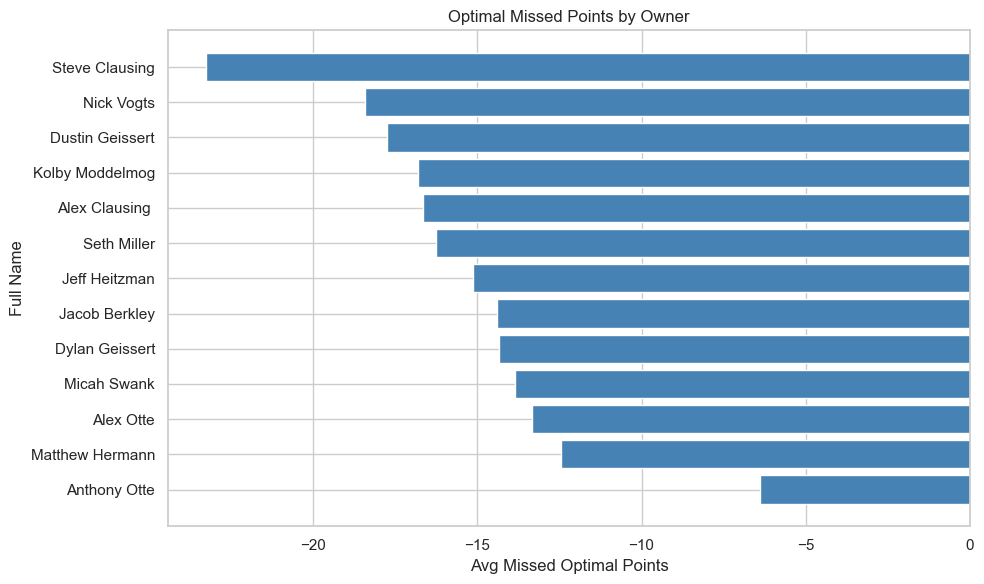

In [133]:
plt.figure(figsize=(10, 6))
plt.barh(df_Avg_Missed_Optimal['Full Name'], df_Avg_Missed_Optimal['Optimal_Missed_Pts'], color='steelblue')
plt.xlabel('Avg Missed Optimal Points')
plt.ylabel('Full Name')
plt.title('Optimal Missed Points by Owner')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
plt.tight_layout()

# Show plot
plt.show()

In [134]:
df_ESPN_Mngr = df_matchups_1.groupby(['Full Name'])["ESPN_missed_Pts"].mean().reset_index().sort_values(by='ESPN_missed_Pts')

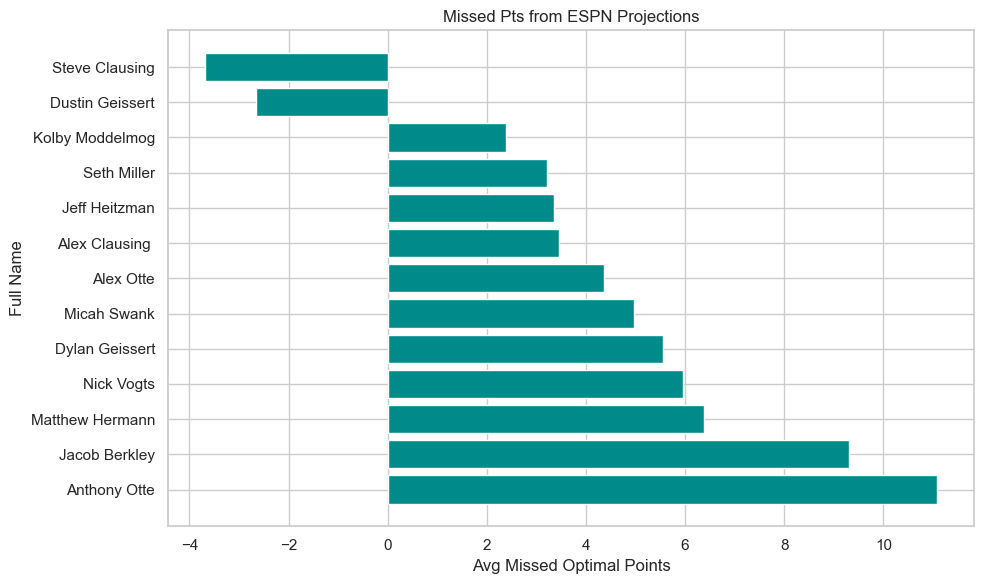

In [135]:
plt.figure(figsize=(10, 6))
plt.barh(df_ESPN_Mngr['Full Name'], df_ESPN_Mngr['ESPN_missed_Pts'], color='darkcyan')
plt.xlabel('Avg Missed Optimal Points')
plt.ylabel('Full Name')
plt.title('Missed Pts from ESPN Projections')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
plt.tight_layout()

# Show plot
plt.show()

In [136]:
df_matchups_1.groupby(['Full Name','Year'])["Optimal_Missed_Pts"].mean().reset_index().sort_values(by='Optimal_Missed_Pts',ascending=False)

,Full Name,Year,Optimal_Missed_Pts
44,Micah Swank,2023,-3.317647
3,Alex Clausing,2021,-3.341176
22,Dylan Geissert,2022,-3.758824
43,Micah Swank,2022,-4.129412
13,Anthony Otte,2022,-4.600000
29,Jeff Heitzman,2022,-4.817647
10,Alex Otte,2022,-5.888235
23,Dylan Geissert,2023,-6.047059
12,Anthony Otte,2021,-6.270588
11,Alex Otte,2023,-6.611765


In [137]:
df_opts_wins = df_matchups_1.groupby(['Full Name','Year'])[["Opts",'Actual_Winner']].sum().reset_index().sort_values(by='Opts',ascending=True)

In [138]:
df_opts_wins

,Full Name,Year,Opts,Actual_Winner
32,Kolby Moddelmog,2019,1907.1,6
57,Steve Clausing,2018,1972.4,6
1,Alex Clausing,2019,2059.9,5
26,Jeff Heitzman,2019,2115.7,9
33,Kolby Moddelmog,2020,2138.4,7
44,Micah Swank,2023,2143.0,7
36,Kolby Moddelmog,2023,2145.2,4
10,Alex Otte,2022,2152.7,7
18,Dylan Geissert,2018,2158.1,7
14,Anthony Otte,2023,2180.8,7


In [139]:
df_Opts_Wins_Yrs = df_matchups_1.groupby(['Full Name']).agg({
    'Opts': 'sum',
    'Actual_Winner': 'sum',
    'Year': 'nunique',
    'Matchup_ID': 'count'}).reset_index()

In [140]:
df_Opts_Wins_Yrs['Opts/gm'] = (df_Opts_Wins_Yrs['Opts']/df_Opts_Wins_Yrs['Matchup_ID']).round(1)
df_Opts_Wins_Yrs['Opts/yr'] = (df_Opts_Wins_Yrs['Opts']/df_Opts_Wins_Yrs['Year']).round(1)
df_Opts_Wins_Yrs['Wins/yr'] = (df_Opts_Wins_Yrs['Actual_Winner']/df_Opts_Wins_Yrs['Year']).round(1)

In [141]:
df_Opts_Wins_Yrs

,Full Name,Opts,Actual_Winner,Year,Matchup_ID,Opts/gm,Opts/yr,Wins/yr
0,Alex Clausing,14453.8,47,6,99,146.0,2409.0,7.8
1,Alex Otte,14127.2,52,6,99,142.7,2354.5,8.7
2,Anthony Otte,6799.3,24,3,51,133.3,2266.4,8.0
3,Dustin Geissert,7395.7,33,3,48,154.1,2465.2,11.0
4,Dylan Geissert,14839.2,61,6,99,149.9,2473.2,10.2
5,Jacob Berkley,2401.6,8,1,17,141.3,2401.6,8.0
6,Jeff Heitzman,14533.5,57,6,99,146.8,2422.2,9.5
7,Kolby Moddelmog,13204.0,43,6,99,133.4,2200.7,7.2
8,Matthew Hermann,5034.2,16,2,34,148.1,2517.1,8.0
9,Micah Swank,13606.1,39,6,99,137.4,2267.7,6.5


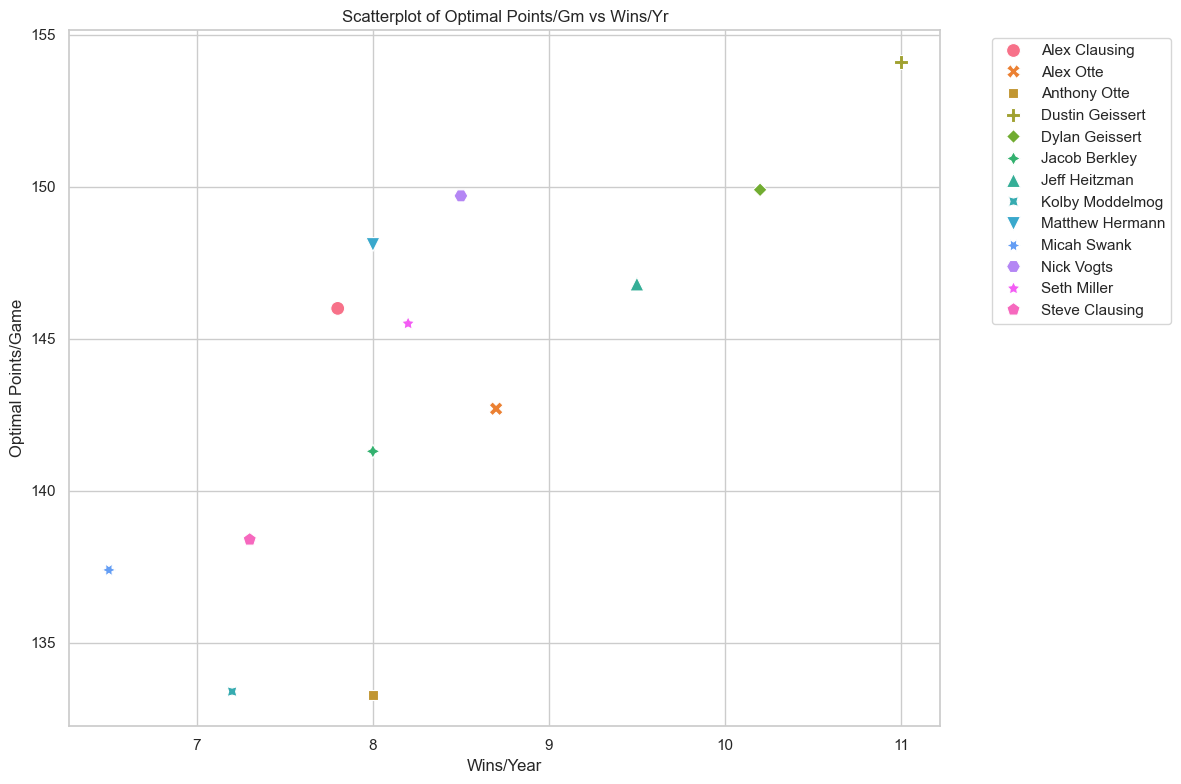

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the scatterplot
sns.scatterplot(data=df_Opts_Wins_Yrs, x='Wins/yr', y='Opts/gm', hue='Full Name', style='Full Name', s=100)

# Add titles and labels
plt.title('Scatterplot of Optimal Points/Gm vs Wins/Yr')
plt.xlabel('Wins/Year')
plt.ylabel('Optimal Points/Game')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

In [143]:
df_opts_wins = df_matchups_1.groupby(['Full Name','Year'])[["Opts",'Actual_Winner']].sum().reset_index().sort_values(by='Opts',ascending=True)

In [144]:
#df_opts_wins

In [145]:
df_opts_wins['Name_Yr'] = df_opts_wins['Full Name']+"_"+df_opts_wins['Year']

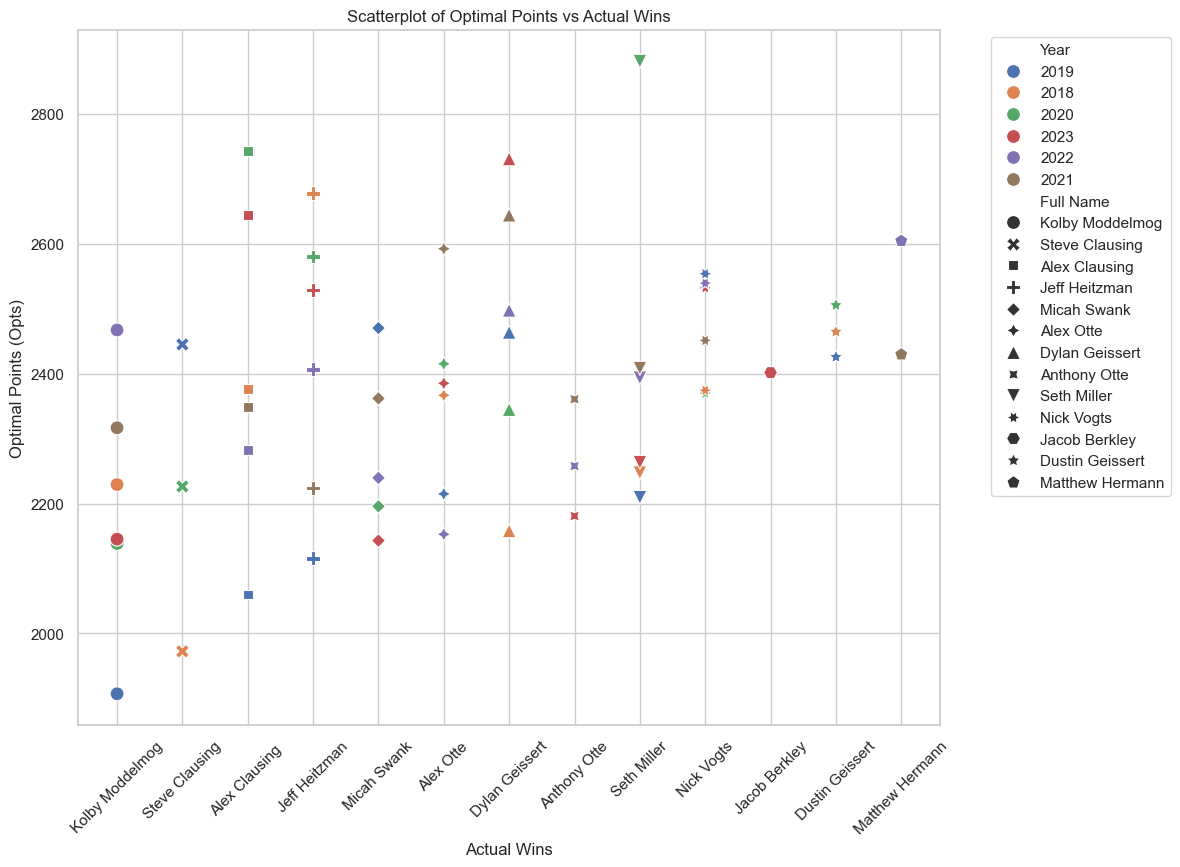

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the scatterplot
sns.scatterplot(data=df_opts_wins, x='Full Name', y='Opts', hue='Year', style='Full Name', s=100)

# Add titles and labels
plt.title('Scatterplot of Optimal Points vs Actual Wins')
plt.xlabel('Actual Wins')
plt.ylabel('Optimal Points (Opts)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

In [147]:
df_matchups_2

,Year,Week,TeamID,Opts,Epts,Apts,First,Last,Full Name,Matchup_ID,Type,Actual_Winner,Optimal_Winner,ESPN_Winner,Optimal_Missed_Pts,ESPN_missed_Pts,Opponent_Apts,Opponent_Opts
0,2023,1,1,134.4,90.3,107.7,Seth,Miller,Seth Miller,2023161,Regular,0,0,0,-26.7,17.4,177.8,176.3
1,2023,1,2,157.5,105.6,134.3,Jeff,Heitzman,Jeff Heitzman,20231211,Regular,1,1,1,-23.2,28.7,104.8,141.2
2,2023,1,3,103.8,88.3,91.5,Nick,Vgts,Nick Vogts,2023137,Regular,1,1,1,-12.3,3.2,87.0,90.0
3,2023,1,5,100.3,76.6,92.4,Micah,Swank,Micah Swank,20231510,Regular,0,0,0,-7.9,15.8,140.1,141.1
4,2023,1,6,176.3,127.5,177.8,Dylan,Geissert,Dylan Geissert,2023161,Regular,1,1,1,1.5,50.3,107.7,134.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,2018,16,7,133.6,101.5,63.2,Kolby,Moddelmog,Kolby Moddelmog,20181675,Playoff,0,1,0,-70.4,-38.3,120.9,122.9
986,2018,16,9,191.3,147.3,161.3,Alex,Otte,Alex Otte,201816911,Playoff,1,1,1,-30.0,14.0,110.8,139.9
987,2018,16,10,124.0,113.5,115.7,Steve,Clausing,Steve Clausing,201816101,Playoff,0,0,0,-8.3,2.2,139.5,147.3
988,2018,16,11,139.9,128.5,110.8,Alex,Clausing,Alex Clausing,201816911,Playoff,0,0,0,-29.1,-17.7,161.3,191.3


In [148]:
df_matchup_stats = df_matchups_2.groupby(['Full Name',"Year"]).agg({
    'Optimal_Missed_Pts': 'sum',
    'Opts': 'sum',
    'Opponent_Opts': 'sum',
    'Actual_Winner': 'sum',
    'Optimal_Winner': 'sum',
    'ESPN_Winner': 'sum',
    'Matchup_ID': 'count'}).reset_index()

In [149]:
df_matchup_stats['Adjusted_Wins'] = df_matchup_stats['Optimal_Winner']-df_matchup_stats['Actual_Winner']

In [150]:
#df_matchup_stats.sort_values(by='Adjusted_Wins')

In [151]:
df_matchup_stats['Name_Year'] = df_matchup_stats['Full Name'] + ' ' + df_matchup_stats['Year'].astype(str)

In [152]:
df_matchup_stats.sort_values(by='Adjusted_Wins', inplace=True)

In [153]:
df_mstats_short = df_matchup_stats.loc[(df_matchup_stats['Adjusted_Wins']>1)|(df_matchup_stats['Adjusted_Wins']< -1)]

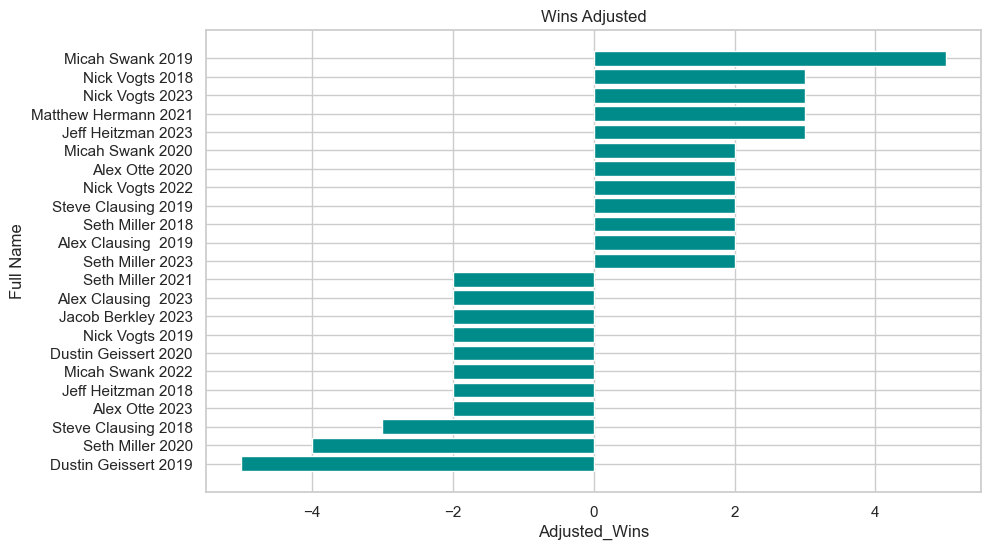

In [154]:
plt.figure(figsize=(10, 6))
plt.barh(df_mstats_short['Name_Year'], df_mstats_short['Adjusted_Wins'], color='darkcyan')
plt.xlabel('Adjusted_Wins')
plt.ylabel('Full Name')
plt.title('Wins Adjusted')
#plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
#plt.tight_layout()

# Show plot
plt.show()

In [155]:
#df_mstats_short.info()

In [159]:
#df_matchup_stats

In [157]:
#df_matchups_1.groupby(['Full Name','Year'])["Optimal_Missed_Pts"].mean().reset_index().sort_values(by='Optimal_Missed_Pts',ascending=False)

In [161]:
df_lineups_all['Year'] = df_lineups_all['Year'].astype('str')

In [181]:
df_lineups_sum = df_lineups_all.merge(tm_owners)

In [182]:
df_lineups_sum['First'] = df_lineups_sum['First'].str.capitalize()
df_lineups_sum['Last'] = df_lineups_sum['Last'].str.capitalize()

In [183]:
df_lineups_sum['Full Name'] = df_lineups_sum['First']+ " " + df_lineups_sum['Last']

In [184]:
df_lineups_sum.drop_duplicates(inplace=True)

In [185]:
df_lineups_sum_1 = df_lineups_sum.loc[df_lineups_sum['Full Name']!='Dave Miller']
df_lineups_sum_1.loc[df_lineups_sum_1['Full Name']=='Nick  Vgts','Full Name']="Nick Vogts"
df_lineups_sum_1.loc[df_lineups_sum_1['Full Name']=='Nick Vgts','Full Name']="Nick Vogts"

In [190]:
df_pos_pts = df_lineups_sum_1.groupby(['Year','Full Name','Slot'])['Actual'].sum().reset_index()

In [191]:
df_pivot = df_pos_pts.pivot_table(index=['Year', 'Full Name'], columns='Slot', values='Actual', aggfunc='sum').reset_index()

In [196]:
df_pivot.drop(columns=['IR','K'],inplace=True)

In [200]:
df_pos_pts = df_pivot.merge(df_matchup_stats[['Full Name','Year','Actual_Winner']])

In [206]:
Winners = pd.DataFrame({"Full Name":["Alex Clausing",'Dylan Geissert','Alex Otte','Seth Miller','Nick Vogts','Dustin Geissert'],'Year':['2023','2022','2021','2020','2019','2018'],'Winner':[1,1,1,1,1,1]})

In [209]:
df_pos_pts_W = df_pos_pts.merge(Winners, how='outer')

In [212]:
df_pos_pts_W['Winner'] = df_pos_pts_W['Winner'].fillna(0)

In [213]:
df_pos_pts_W.select_dtypes(include=['number']).corr()

,Bench,D/ST,Flex,QB,RB,TE,WR,Actual_Winner,Winner
Bench,1.000000,0.119463,-0.200633,0.044971,-0.056222,0.302974,0.146268,0.090045,-0.066509
D/ST,0.119463,1.000000,-0.012498,-0.159377,-0.021888,0.208730,-0.143675,0.178232,-0.009429
Flex,-0.200633,-0.012498,1.000000,0.018327,0.126550,-0.021403,0.376111,0.304746,0.031224
QB,0.044971,-0.159377,0.018327,1.000000,0.119040,-0.110180,0.183960,0.367649,0.195623
RB,-0.056222,-0.021888,0.126550,0.119040,1.000000,-0.077911,0.011515,0.416477,0.468428
TE,0.302974,0.208730,-0.021403,-0.110180,-0.077911,1.000000,-0.028974,0.045775,0.123174
WR,0.146268,-0.143675,0.376111,0.183960,0.011515,-0.028974,1.000000,0.497844,0.021694
Actual_Winner,0.090045,0.178232,0.304746,0.367649,0.416477,0.045775,0.497844,1.000000,0.358905
Winner,-0.066509,-0.009429,0.031224,0.195623,0.468428,0.123174,0.021694,0.358905,1.000000
